In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from joblib import dump
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_news = pd.read_csv("https://raw.githubusercontent.com/gitsim02/FoundationProject-1/main/data/Reliance_sentiment.csv")
df_price = pd.read_csv("https://raw.githubusercontent.com/gitsim02/FoundationProject-1/main/data/reliance_prices.csv")
df_news['date'] = pd.to_datetime(df_news.date)
df_price['Date'] = pd.to_datetime(df_price.Date)

df_combined = pd.merge(left=df_price,right=df_news,how="left",left_on = 'Date',right_on='date')


In [3]:
df_combined.drop(['date'],axis=1,inplace=True)

In [4]:
df_combined[['Date','Close','1d_diff']].head()

,Date,Close,1d_diff
0,2016-12-13,515.018127,-9.757507
1,2016-12-14,524.775635,3.244202
2,2016-12-15,521.531433,-2.080261
3,2016-12-16,523.611694,-2.674622
4,2016-12-19,526.286316,2.303162


In [5]:
df_combined.fillna(0.0,inplace=True)

In [6]:
df_combined['next_day_close'] = df_combined['Close'] - df_combined['1d_diff']
df_combined['next5_day_close'] = df_combined['Close'] - df_combined['5d_diff']
df_combined['next10_day_close'] = df_combined['Close'] - df_combined['10d_diff']

In [7]:
df_combined['1d_up_down'] = np.where(df_combined['next_day_close'] > df_combined['Close'],1,0)
df_combined['5d_up_down'] = np.where(df_combined['next5_day_close'] > df_combined['Close'],1,0)
df_combined['10d_up_down'] = np.where(df_combined['next10_day_close'] > df_combined['Close'],1,0)

In [8]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 1383
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1384 non-null   datetime64[ns]
 1   Open              1384 non-null   float64       
 2   High              1384 non-null   float64       
 3   Low               1384 non-null   float64       
 4   Close             1384 non-null   float64       
 5   Adj Close         1384 non-null   float64       
 6   Volume            1384 non-null   int64         
 7   1d_diff           1384 non-null   float64       
 8   5d_diff           1384 non-null   float64       
 9   10d_diff          1384 non-null   float64       
 10  SMA3              1384 non-null   float64       
 11  SMA5              1384 non-null   float64       
 12  SMA9              1384 non-null   float64       
 13  SMA15             1384 non-null   float64       
 14  SMA30             1384 n

In [9]:
X_features = set(list(df_combined.columns)) - set(['Date','Open','High','Low','Adj Close','Close','Volume'])
X_features = list(X_features)

In [10]:
X_features

['next10_day_close',
 'SMA30',
 'next_day_close',
 'EMA3',
 '10d_diff',
 'next5_day_close',
 '10d_up_down',
 'EMA30',
 'EMA5',
 'EMA15',
 '5d_up_down',
 'news_senti_comp',
 'title_senti_comp',
 'SMA9',
 '1d_up_down',
 '5d_diff',
 'EMA9',
 '1d_diff',
 'SMA3',
 'avg_senti_comp',
 'SMA15',
 'SMA5',
 'Volume_100k']

In [11]:
def loglinear_model_build_eval(X,Y,train_size=0.7):
    
    
    regressor_obj = LogisticRegression(random_state = 101, 
                               max_iter = 1000)
    
    ## train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    shuffle=False,
                                                    train_size = train_size,
                                                    random_state = 80)
    
    print(f"Train size : {X_train.shape}; Test Size : {X_test.shape}")
    
    # transformations
    scaler = StandardScaler()
    
    # pipeline
    logreg = Pipeline(steps=[('scaler', scaler),
                          ('regressor', regressor_obj )])
    
    #fit train set
    logreg.fit(X_train,y_train)
    
    print(f"Intercept : {logreg['regressor'].intercept_}")
    
    print(f"Coefficient : {dict(zip(X, np.round(logreg['regressor'].coef_[0], 2)))}")
    
    y_pred = logreg.predict(X_test)
    
    accuracy_s = accuracy_score(y_test,y_pred)
    
    recall_s = recall_score(y_test,y_pred)
    
    precision_s = precision_score(y_test,y_pred)
    
    cm = confusion_matrix(y_test,y_pred, labels = [1,0])
    
    cr = classification_report(y_test,y_pred,labels=[1,0])
    
    return y_pred,y_test,X_test,accuracy_s,recall_s,precision_s,cm,cr, logreg

## 1d classify

In [12]:
X_features_1d = set(X_features) - set(['5d_diff','10d_diff','next5_day_close','next10_day_close','1d_up_down',
                                      '5d_up_down','10d_up_down','next_day_close','1d_diff',
                                      'title_senti_comp','avg_senti_comp'])
X_features_1d = list(X_features_1d)

In [13]:
X_features_1d

['SMA30',
 'EMA9',
 'news_senti_comp',
 'SMA3',
 'EMA3',
 'SMA15',
 'SMA9',
 'SMA5',
 'Volume_100k',
 'EMA30',
 'EMA5',
 'EMA15']

In [14]:
X1d = df_combined[X_features_1d]
y1d = df_combined['1d_up_down']

In [15]:
y_pred1,y_test1,X_test1,accuracy_s1,recall_s1,precision_s1,cm1,cr1,log_model_1d = loglinear_model_build_eval(X1d,y1d,)
                                                                                               

Train size : (968, 12); Test Size : (416, 12)
Intercept : [0.07450863]
Coefficient : {'SMA30': -0.06, 'EMA9': 0.07, 'news_senti_comp': -0.03, 'SMA3': -0.1, 'EMA3': 0.13, 'SMA15': 0.19, 'SMA9': 0.15, 'SMA5': -0.2, 'Volume_100k': -0.0, 'EMA30': -0.34, 'EMA5': 0.04, 'EMA15': 0.07}


In [16]:
accuracy_s1

0.4639423076923077

In [17]:
recall_s1

0.02702702702702703

In [18]:
precision_s1

0.46153846153846156

In [19]:
print(cr1)

              precision    recall  f1-score   support

           1       0.46      0.03      0.05       222
           0       0.46      0.96      0.63       194

    accuracy                           0.46       416
   macro avg       0.46      0.50      0.34       416
weighted avg       0.46      0.46      0.32       416



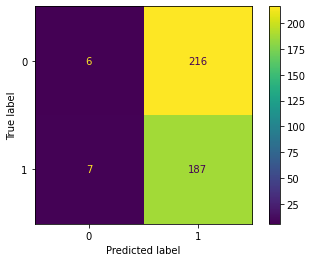

In [31]:
ConfusionMatrixDisplay(cm1).plot()

## 5d Classify

In [21]:
X_features_5d = set(X_features) - set(['5d_diff','10d_diff','next5_day_close','next10_day_close','1d_up_down',
                                      '5d_up_down','10d_up_down','next_day_close','1d_diff',
                                       'title_senti_comp','avg_senti_comp'])
X_features_5d = list(X_features_5d)

In [22]:
X5d = df_combined[X_features_5d]
y5d = df_combined['5d_up_down']

In [23]:
y_pred5,y_test5,X_test5,accuracy_s5,recall_s5,precision_s5,cm5,cr5,log_model_5d = loglinear_model_build_eval(X5d,y5d,)


Train size : (968, 12); Test Size : (416, 12)
Intercept : [0.32326283]
Coefficient : {'SMA30': -0.06, 'EMA9': 0.15, 'news_senti_comp': 0.07, 'SMA3': -0.46, 'EMA3': -0.39, 'SMA15': -0.02, 'SMA9': 0.53, 'SMA5': 0.45, 'Volume_100k': 0.08, 'EMA30': -0.42, 'EMA5': -0.06, 'EMA15': 0.11}


In [24]:
accuracy_s5

0.4639423076923077

In [25]:
recall_s5

0.06726457399103139

In [26]:
precision_s5

0.5

## 10d Classify

In [27]:
X_features_10d = set(X_features) - set(['5d_diff','10d_diff','next5_day_close','next10_day_close','1d_up_down',
                                      '5d_up_down','10d_up_down','next_day_close','1d_diff',
                                       'title_senti_comp','avg_senti_comp'])
X_features_10d = list(X_features_5d)

In [28]:
X10d = df_combined[X_features_10d]
y10d = df_combined['10d_up_down']

In [29]:
y_pred10,y_test10,X_test10,accuracy_s10,recall_s10,precision_s10,cm10,cr10,log_model_10d = loglinear_model_build_eval(X10d,y10d,)


Train size : (968, 12); Test Size : (416, 12)
Intercept : [0.37860594]
Coefficient : {'SMA30': 0.02, 'EMA9': 0.08, 'news_senti_comp': -0.03, 'SMA3': -0.41, 'EMA3': -0.23, 'SMA15': 0.27, 'SMA9': 0.12, 'SMA5': 0.12, 'Volume_100k': 0.34, 'EMA30': -0.34, 'EMA5': -0.09, 'EMA15': 0.12}


In [30]:
accuracy_s10

0.4807692307692308

## KNN Classifier

In [32]:
def knn_classifier(X,y,train_size=0.7, neighbors=10):
    
    ## train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=False,
                                                    train_size = train_size,
                                                    random_state = 80)
    
    scaler = MinMaxScaler()
    
    scaler.fit(X_train)
    
    x_train_scaled = scaler.transform(X_train)
    x_test_scaled = scaler.transform(X_test)
    
    knn_clf = KNeighborsClassifier( n_neighbors = neighbors )
    
    return x_train_scaled,y_train,x_test_scaled,y_test,knn_clf
    

## 1d classification

In [33]:
x_train_scaled_1, y_train_1, x_test_scaled_1, y_test_1, knn_1 = knn_classifier(X1d,y1d,neighbors=5)

In [34]:
knn_1.fit(x_train_scaled_1,y_train_1)

knn_test_pred_1 = pd.DataFrame( { 'actual':  y_test_1,
                                'predicted': knn_1.predict( x_test_scaled_1 ) } )

cm_knn_1 = confusion_matrix(knn_test_pred_1.actual, knn_test_pred_1.predicted, labels = [1,0])

knn_cm_plot = ConfusionMatrixDisplay(cm_knn_1, 
                                 display_labels=['Up', 'Down'])

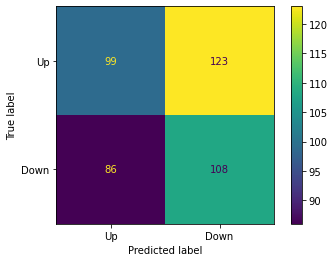

In [35]:
knn_cm_plot.plot()

In [36]:
print(classification_report(knn_test_pred_1.actual, knn_test_pred_1.predicted))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51       194
           1       0.54      0.45      0.49       222

    accuracy                           0.50       416
   macro avg       0.50      0.50      0.50       416
weighted avg       0.50      0.50      0.50       416



In [37]:
accuracy_score(knn_test_pred_1.actual,knn_test_pred_1.predicted)

0.49759615384615385

In [38]:
recall_score(knn_test_pred_1.actual,knn_test_pred_1.predicted)

0.44594594594594594

## 5d classification

In [39]:
x_train_scaled_5, y_train_5, x_test_scaled_5, y_test_5, knn_5 = knn_classifier(X5d,y5d,neighbors=5)

In [40]:
knn_5.fit(x_train_scaled_5,y_train_5)

knn_test_pred_5 = pd.DataFrame( { 'actual':  y_test_5,
                                'predicted': knn_5.predict( x_test_scaled_5 ) } )

cm_knn_5 = confusion_matrix(knn_test_pred_5.actual, knn_test_pred_5.predicted, labels = [1,0])

knn_cm_plot = ConfusionMatrixDisplay(cm_knn_5, 
                                 display_labels=['Up', 'Down'])

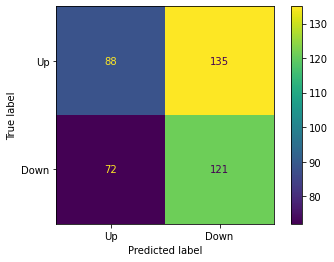

In [41]:
knn_cm_plot.plot()

In [42]:
accuracy_score(knn_test_pred_5.actual,knn_test_pred_5.predicted)

0.5024038461538461

In [43]:
# for label 1
recall_score(knn_test_pred_5.actual,knn_test_pred_5.predicted)

0.39461883408071746

In [44]:
print(classification_report(knn_test_pred_5.actual, knn_test_pred_5.predicted))

              precision    recall  f1-score   support

           0       0.47      0.63      0.54       193
           1       0.55      0.39      0.46       223

    accuracy                           0.50       416
   macro avg       0.51      0.51      0.50       416
weighted avg       0.51      0.50      0.50       416



## 10d Classification

In [45]:
x_train_scaled_10, y_train_10, x_test_scaled_10, y_test_10, knn_10 = knn_classifier(X10d,y10d,neighbors=5)

In [46]:
knn_10.fit(x_train_scaled_10,y_train_10)

knn_test_pred_10 = pd.DataFrame( { 'actual':  y_test_10,
                                'predicted': knn_10.predict( x_test_scaled_10 ) } )

cm_knn_10 = confusion_matrix(knn_test_pred_10.actual, knn_test_pred_10.predicted, labels = [1,0])

knn_cm_plot = ConfusionMatrixDisplay(cm_knn_10, 
                                 display_labels=['Up', 'Down'])

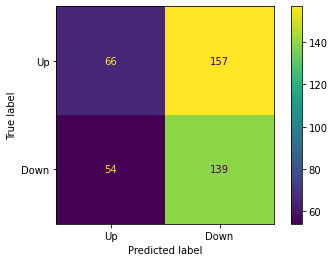

In [47]:
knn_cm_plot.plot()

In [48]:
accuracy_score(knn_test_pred_10.actual,knn_test_pred_10.predicted)

0.49278846153846156

In [49]:
# for label 1
recall_score(knn_test_pred_10.actual,knn_test_pred_10.predicted)

0.29596412556053814

In [50]:
print(classification_report(knn_test_pred_10.actual, knn_test_pred_10.predicted))

              precision    recall  f1-score   support

           0       0.47      0.72      0.57       193
           1       0.55      0.30      0.38       223

    accuracy                           0.49       416
   macro avg       0.51      0.51      0.48       416
weighted avg       0.51      0.49      0.47       416

